## Running MS2LDA

In [1]:
#%pip install requests 
import requests
from matchms.importing import load_from_mgf
from io import StringIO
url = "https://raw.githubusercontent.com/matchms/matchms/master/tests/testdata/pesticides.mgf"
filename = "pesticides.mgf"
response = requests.get(url)
if response.status_code == 200:
    with open(f"../datasets/{filename}", "wb") as f:
        f.write(response.content)
    print(f"File downloaded and saved as {filename}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded and saved as pesticides.mgf


In [1]:
%matplotlib agg
import ms2lda

In [2]:
preprocessing_parameters = {
    "min_mz": 0,
    "max_mz": 1000,
    "max_frags": 1000,
    "min_frags": 3,
    "min_intensity": 0.01,
    "max_intensity": 1
}

In [3]:
convergence_parameters = {
    "step_size": 50,
    "window_size": 10,
    "threshold": 0.001,
    "type": "perplexity_history"
}

In [4]:
annotation_parameters = {
    "criterium": "best", # return cluster with most compounds in it after optimization ("best" also an option)
    "cosine_similarity": 0.70, #0.8 how similar are the spectra compared to motifs in the optimization
    "n_mols_retrieved": 5 # 10 molecules retrieved from database by Spec2Vec
}

In [5]:
n_motifs = 100
n_iterations = 2000

In [6]:
model_parameters = {
    "rm_top": 4, 
    "min_cf": 50,
    "min_df": 10,
    "alpha": 0.6, #A higher alpha makes the document preferences "smoother" over topics
    "eta": 0.01, #and a higher eta makes the topic preferences "smoother" over words.
    "seed": 42,
}

In [7]:
train_parameters = {
    "parallel": 3,
    "workers": 0, 
}

In [8]:
dataset_parameters = {
    "acquisition_type": "DDA",
    "significant_digits": 3,
    "charge": 1,
    "name": "test",
    "output_folder": f"mytest10", 
}

In [9]:
fingerprint_parameters = {
    "fp_type": "rdkit",
    "threshold": 0.8,
}

In [10]:
motif_parameter = 20

In [11]:
dataset = "../datasets/mzmine443_tomato_spiked_sirius.mgf"

In [12]:
motif_spectra, optimized_motifs, motif_fps = ms2lda.run(dataset, n_motifs=n_motifs, n_iterations=n_iterations,
        dataset_parameters=dataset_parameters,
        train_parameters=train_parameters,
        model_parameters=model_parameters,
        convergence_parameters=convergence_parameters,
        annotation_parameters=annotation_parameters,
        motif_parameter=motif_parameter,
        preprocessing_parameters=preprocessing_parameters,
        fingerprint_parameters=fingerprint_parameters)

Cleaning spectra ... 7825 spectra left


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]C:\Users\dietr004\AppData\Local\anaconda3\envs\MS2LDA\lib\site-packages\MS2LDA\modeling.py:54: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(convergence_parameters["step_size"], **train_parameters)
 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [01:17<00:13,  2.29s/it]

Model has converged
Loading Spec2Vec model ...


Searches for candidates ...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.38it/s]


m2m folder stored
convergence curve stored
network stored
Visualization data saved to: mytest10\ms2lda_viz.json


In [13]:
%matplotlib inline

In [14]:
import tomotopy as tp
ms2lda = tp.LDAModel.load("mytest10\ms2lda.bin")
len(ms2lda.docs)

7825

In [15]:
ms2lda.docs[7].get_topics()

[(47, 0.9912713170051575),
 (23, 0.0002537984983064234),
 (8, 0.00019122868252452463),
 (29, 0.00015760115638840944),
 (43, 0.0001523608952993527),
 (33, 0.00015080420416779816),
 (28, 0.00013757243868894875),
 (6, 0.0001348143705399707),
 (70, 0.00013209538883529603),
 (10, 0.00012715872435364872)]

In [16]:
ms2lda.retrieve_spec4doc(7)

Spectrum(precursor m/z=187.09, 3 fragments between 46.1 and 187.1)

In [17]:
ms2lda.retrieve_spec4doc(7).metadata

{'feature_id': '9',
 'charge': 1,
 'scans': '9',
 'num_peaks': '3',
 'ms_level': '2',
 'retention_time': 75.66,
 'precursor_mz': 187.08666,
 'ionmode': 'positive',
 'retention_index': None,
 'id': 'spec_7'}

(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Spectrum'}, xlabel='m/z', ylabel='Intensity'>)

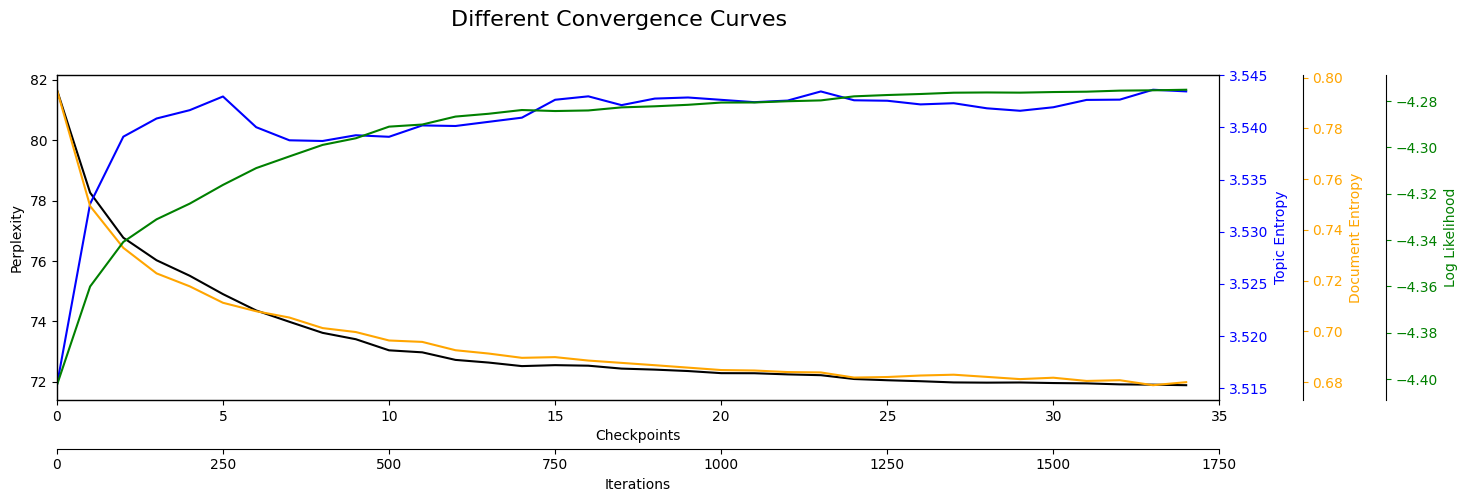

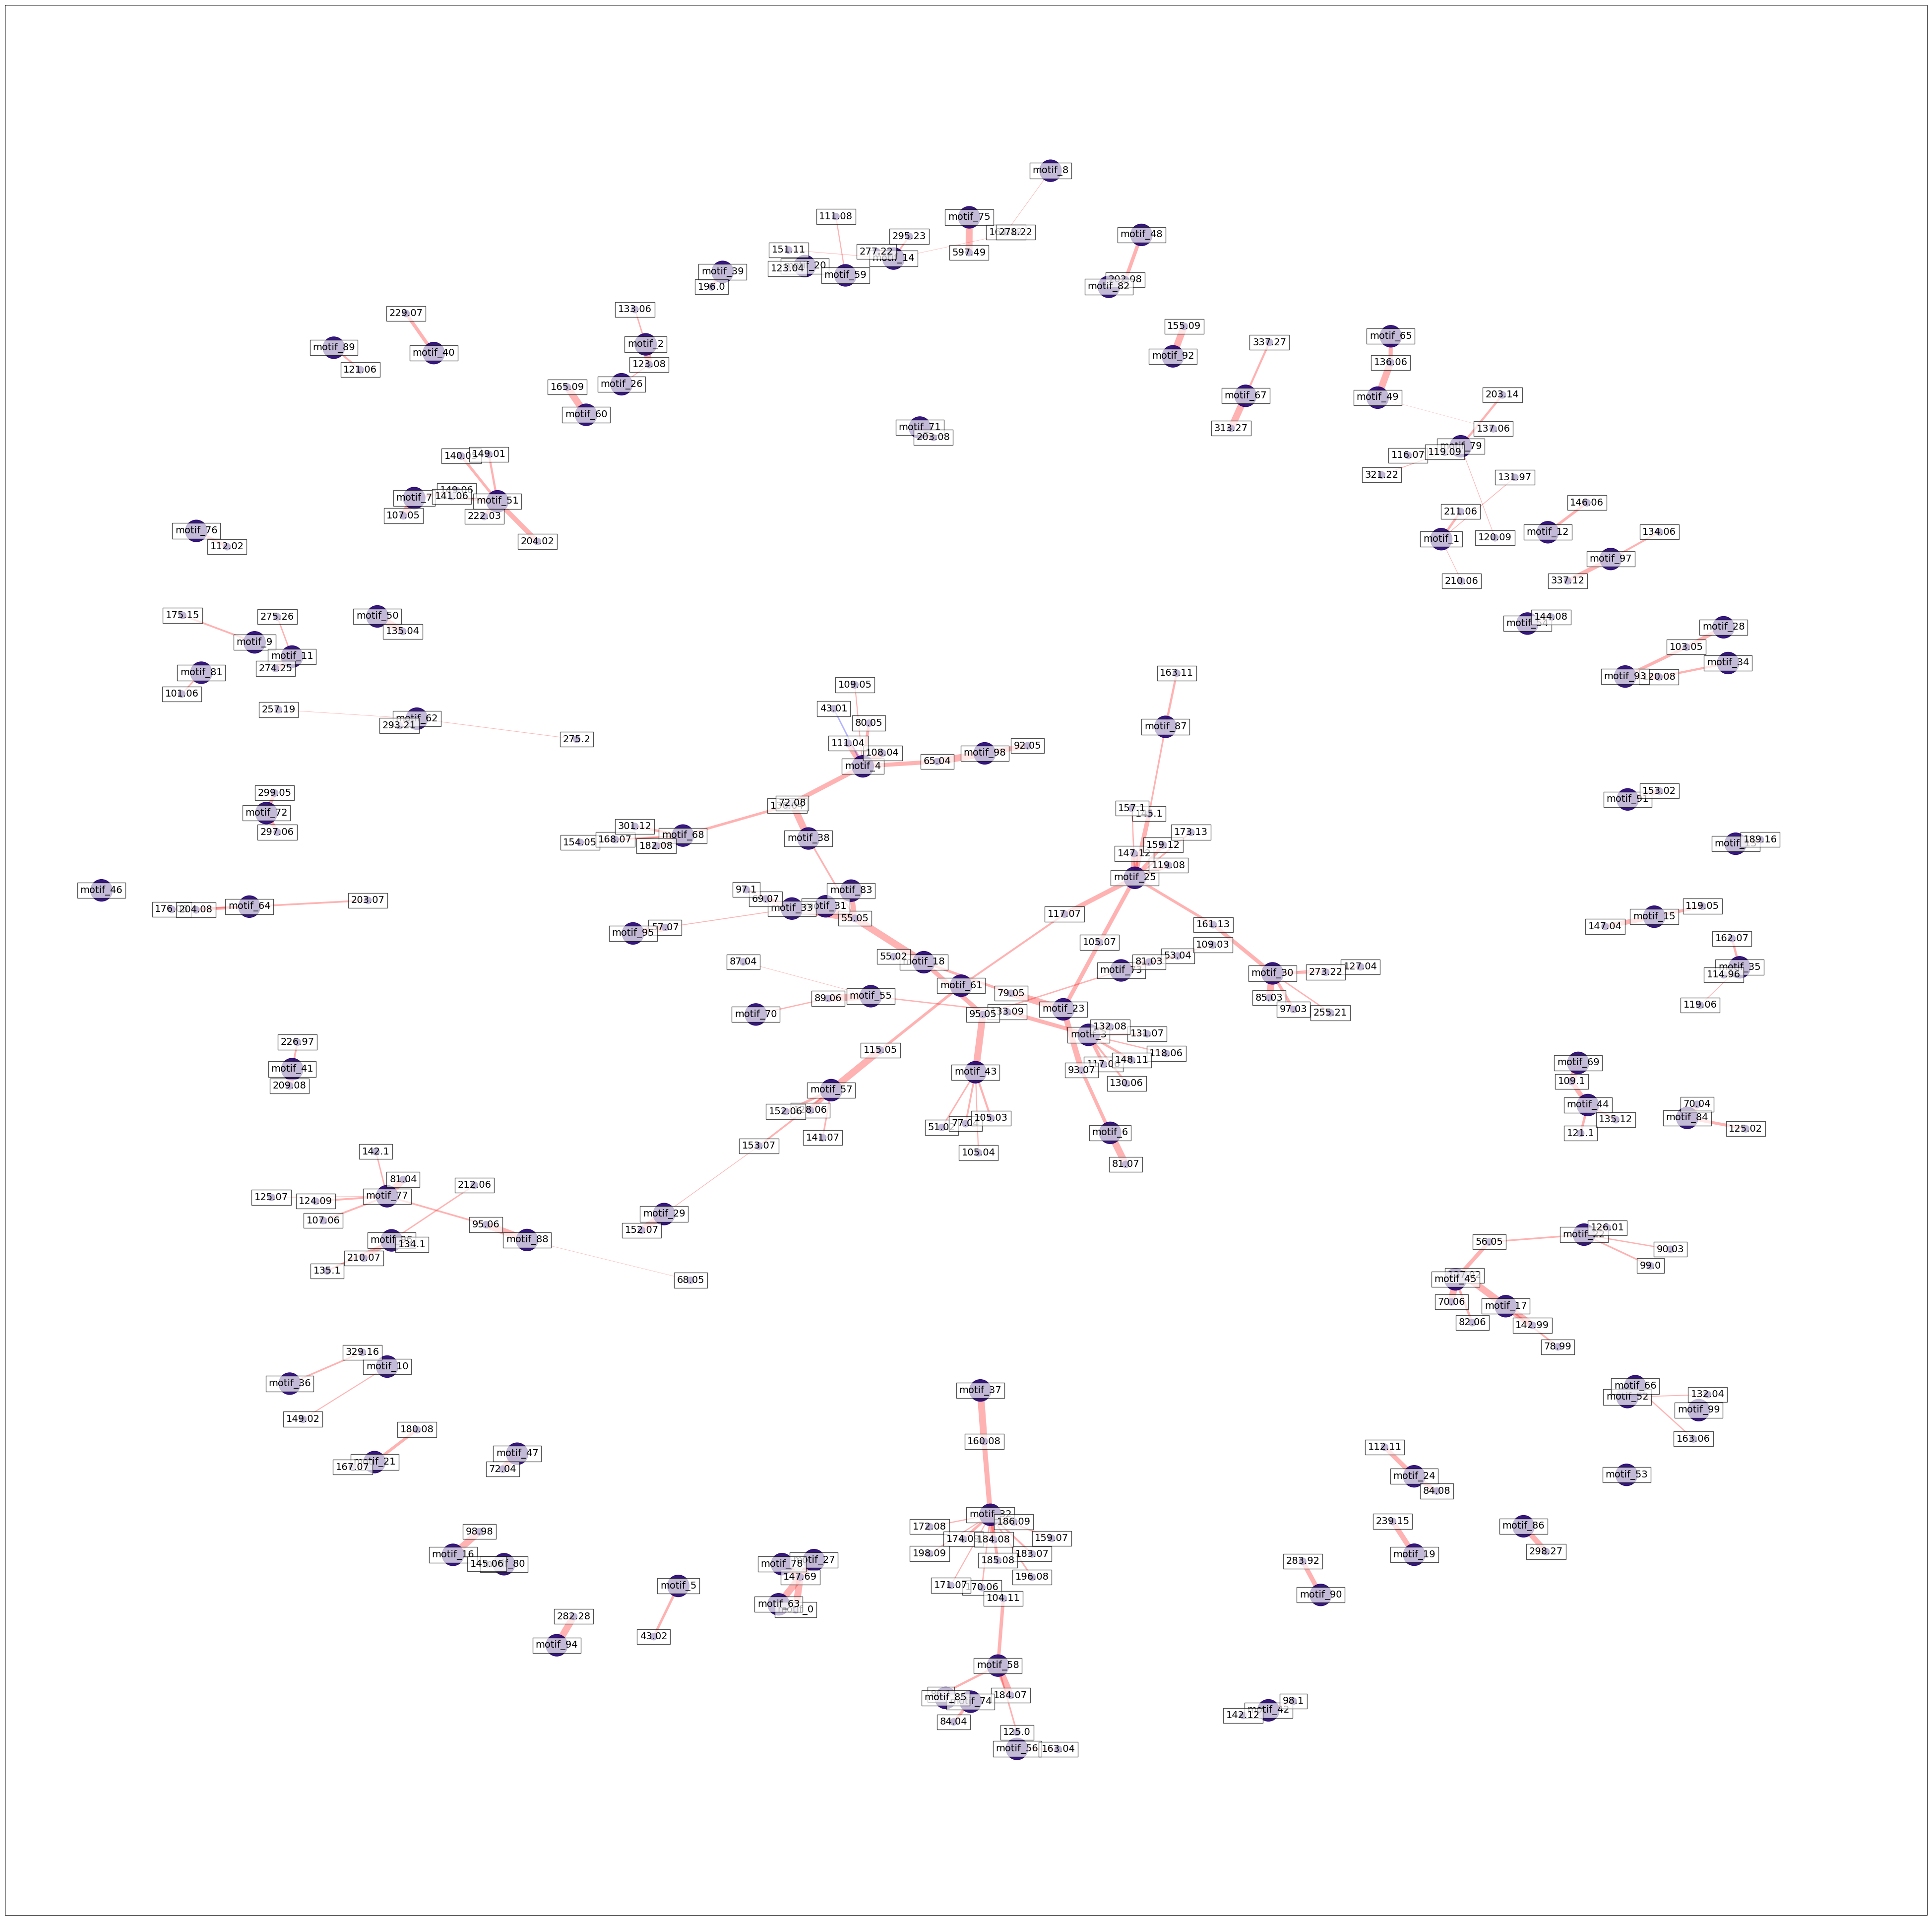

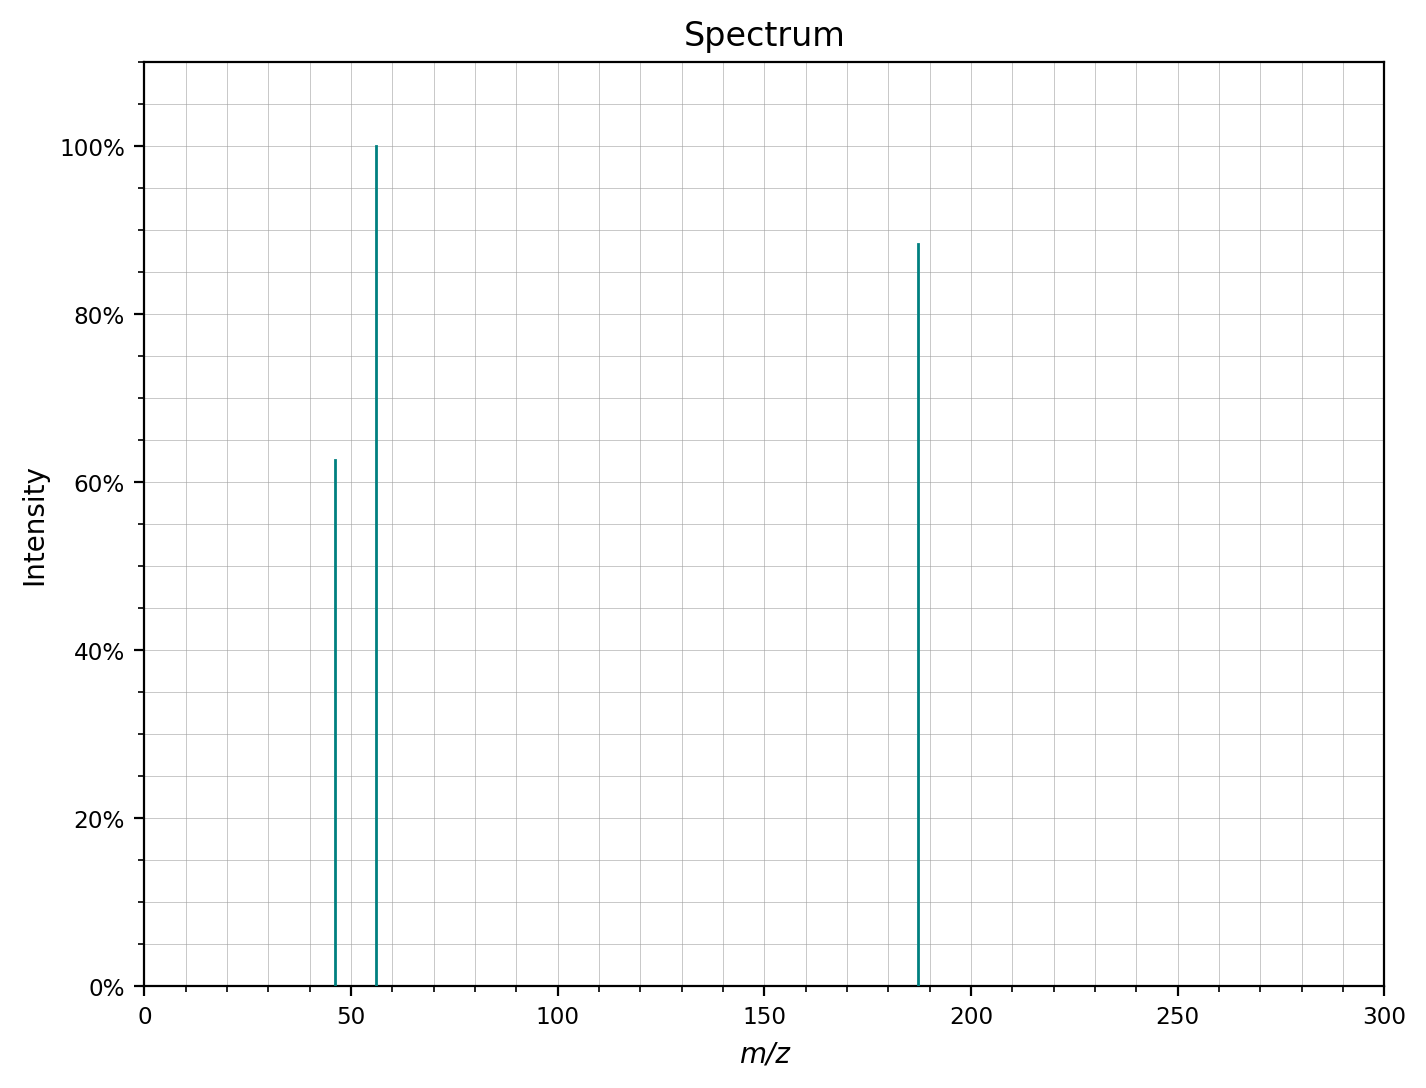

In [18]:
ms2lda.retrieve_spec4doc(7).plot()

In [19]:
ms2lda.retrieve_spec4doc(7).peaks.mz

array([ 46.064991,  55.934158, 187.086426])

In [20]:
motif_spectra[47].peaks.mz

array([ 46.065,  72.044, 227.2  , 241.216, 285.242, 297.24 , 319.299,
       336.326, 337.329, 339.251])

---

## Screening for spectra from experiments, motifs or motifDB

In [32]:
motifDB_query = "QUERY scaninfo(MS2DATA) WHERE MS2PROD=72.04"

In [33]:
screening_hits = ms2lda.screen_spectra(motifDB=dataset_parameters["output_folder"] + "/motifDB.json", motifs_stored=dataset_parameters["output_folder"] + "/motifDB.json", motifDB_query=motifDB_query, output_folder=dataset_parameters["output_folder"])

Loading Spec2Vec model ...
TOTAL QUERIES 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.70it/s]


In [34]:
screening_hits

""


In [30]:
screening_hits.loc[screening_hits.ref_motif_id == "motif_1"]

AttributeError: 'DataFrame' object has no attribute 'ref_motif_id'

---

In [33]:
from ms2lda.Add_On.MassQL.MassQL4MotifDB import load_motifDB_excel

In [34]:
ms1, ms2 = load_motifDB_excel("DDA-Pesticide_100/motifDB_optimized.xlsx")

In [35]:
ms1

,Unnamed: 0,frag_mz,frag_intens,loss_mz,loss_intens,charge,ms2accuracy,short_annotation,annotation,motif_id,motifset,scan,ms1scan
0,0,110.06,0.290437,NaN,NaN,1,0.0005,"['Nc1ccc(S(=O)(=O)Nc2cnc3ccccc3n2)cc1', 'CCCCN...",NaN,motif_99,DDA-Pesticide-Neurotox,3ac88041aea008002ac59ead6b354d86,0


In [46]:
x = ms1.to_dict()
y = ms2.to_dict()

In [44]:
pd.DataFrame(x)

,Unnamed: 0,frag_mz,frag_intens,loss_mz,loss_intens,charge,ms2accuracy,short_annotation,annotation,motif_id,motifset,scan,ms1scan
0,0,110.06,0.290437,NaN,NaN,1,0.0005,"['Nc1ccc(S(=O)(=O)Nc2cnc3ccccc3n2)cc1', 'CCCCN...",NaN,motif_99,DDA-Pesticide-Neurotox,3ac88041aea008002ac59ead6b354d86,0


In [49]:
z = {
    "x": x,
    "y": y,
}

In [50]:
pd.DataFrame(z["x"])

,Unnamed: 0,frag_mz,frag_intens,loss_mz,loss_intens,charge,ms2accuracy,short_annotation,annotation,motif_id,motifset,scan,ms1scan
0,0,110.06,0.290437,NaN,NaN,1,0.0005,"['Nc1ccc(S(=O)(=O)Nc2cnc3ccccc3n2)cc1', 'CCCCN...",NaN,motif_99,DDA-Pesticide-Neurotox,3ac88041aea008002ac59ead6b354d86,0


In [51]:
with open("motifDB_test.json", "w") as outfile:
    json.dump(z, outfile)

In [55]:
with open("motifDB_test.json", "r") as infile:
    mDB = json.load(infile)

In [57]:
pd.DataFrame(mDB["x"])

,Unnamed: 0,frag_mz,frag_intens,loss_mz,loss_intens,charge,ms2accuracy,short_annotation,annotation,motif_id,motifset,scan,ms1scan
0,0,110.06,0.290437,NaN,NaN,1,0.0005,"['Nc1ccc(S(=O)(=O)Nc2cnc3ccccc3n2)cc1', 'CCCCN...",NaN,motif_99,DDA-Pesticide-Neurotox,3ac88041aea008002ac59ead6b354d86,0
